In [1]:
# ei_selective.ipynb
# This notebook is used to create a balanced network of excitatory and inhibitory units that become selective
# for particular input patterns.

# By Sergio Verduzco Flores        August 2017

from sirasi import *
from matplotlib import pyplot as plt
import numpy as np
import time
from mpl_toolkits.axes_grid1 import ImageGrid

The cells below:
* Create two NxN layers, one excitatory, and one inhibitory.
* Connect the layers with center-excitation surround-inhibition connectivity. E-E connections use
  Hebbian learning with substractive normalization, I-E connections use homeostatic inhibition,
  similar to Moldakarimov06 (in ei_net.ipynb).
* Create an input layer where the activity of each unit is a function of the current input pattern.
* Connects the input layer to E,I layers using a connection pattern based on a Gaussian kernel, and
  using BCM synapses.
* Runs a simulation where input patterns are randomly selected and presented sequentially, similarly
  to the way this was done in the test3,4,5 notebooks.
  
The experiment consists of finding whether selectivity to patterns will arise in the units.
- - -


In [2]:
# create some utility functions
def make_fe(th, eps): # returns a function as in Eq. 1 of the paper
    return lambda x : np.sqrt( eps * np.log( 1. + np.exp( (x - th)/eps ) ) )
def make_fi(th, eps): # returns a function as in Eq. 2 of the paper
    return lambda x: eps * np.log( 1. + np.exp( (x - th)/eps ) ) 
def make_pulse(t_init, t_end): # returns f(t) = 1 if t_init < t < t_end, 0 otherwise
    return lambda t : 1. if (t_init < t and t < t_end) else 0.
def make_sin_pulse(t_init, t_end, per): # the stimulus used in Moldakarimov et al.
    return lambda t : 1. + np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) if (t_init < t and t < t_end) else 0.
def r(i,j,sigma): # A Gaussian function with s.d. sigma, applied to i-j
    return (1./(sigma*np.sqrt(2*np.pi))) * np.exp( -0.5*( ((i-j)/sigma)**2 ) )
def plot_stuff(data,exc,inh,inp):
    #fig.clf()
    #plt.close()
    N = int(round(np.sqrt(len(exc))))
    Nsq = len(exc)
    fig = plt.figure(figsize=(10,10))
    for i in range(Nsq):
        ax = fig.add_subplot(N,N,i+1)
        ax.clear()
        plt.ylim(-0.02, 2.5)
        ax.plot(data[0], data[1][exc[i]], 'b', data[0], data[1][inh[i]], 'r',
                data[0], N*data[1][inp[i]], 'k', figure=fig)
    #fig.canvas.draw()
    plt.show()

In [3]:
""" Create and connect the E,I layers.
    EI connections are arranged in an annulus.
    EE connections are in a circle.
    IE connections are in a circle.
"""

######## CREATE THE NETWORK
md = 0.1 # minimum delay of the connections
topo = topology() # the topology class. Used to create spatially patterned connections
net_params = {'min_delay' : md, 'min_buff_size' : 3, 'rtol':1e-4, 'atol':1e-4 } 
net = network(net_params)

######## CREATE THE E,I UNITS
N = 5 # Each layer will have N*N units
L = (N/2.) + 2./N # side length of the square unit grids
exc_params = {'tau' : np.random.uniform(2., 3.5, N*N), 
              'function' : make_fe(0.3, 0.2), 
              'type' : unit_types.custom_fi, 
              'init_val' : np.random.uniform(0., 0.6, N*N), 
              'tau_fast' : 0.2, 
              'tau_slow' : 20. } # this tau_slow controls stability of BCM
inh_params = {'tau' : np.random.uniform(2.5, 4., N*N), 
              'function' : make_fi(0.4, 0.2), 
              'type' : unit_types.custom_fi, 
              'init_val' : np.random.uniform(0., 0.6, N*N), 
              'tau_fast' : 0.2, 
              'tau_slow' : 20. }
exc_geom = {'shape' : 'sheet', 'extent' : [L, L], 'arrangement' : 'grid', 
            'rows' : N, 'columns' : N, 'center' : [0., 0.]}
inh_geom = {'shape' : 'sheet', 'extent' : [L, L], 'arrangement' : 'grid', 
            'rows' : N, 'columns' : N, 'center' : [0., 0.]}

exc = topo.create_group(net, exc_geom, exc_params)
inh = topo.create_group(net, inh_geom, inh_params)

######## SET E-I CONNECTIONS
# connection specifications
EI_conn = {'connection_type' : 'convergent',
           'mask' : {'annular':{'inner_radius' : 1.1, 'outer_radius':4.1}},
           'kernel' : {'linear' : {'c' : 1., 'a' : 0.2}},
           'delays' : {'linear' : {'c' : md, 'a' : 0.3}},
           'weights' : {'uniform' : {'low' : 0.5, 'high' : 0.8}},
           #'number_of_connections' : 10, # use when more inhibition is needed
           'edge_wrap' : True,
           'boundary' : {'center' : [0.,0.], 'extent' : [L, L]}
          }
# synapse specifications
EI_syn = {'type' : synapse_types.static}
# connect
topo.topo_connect(net, exc, inh, EI_conn, EI_syn)

######## SET E-E CONNECTIONS
# connection specifications
EE_conn = {'connection_type' : 'divergent',
           'allow_autapses' : True, # True is the default. Just making it explicit.
           'mask' : {'circular':{'radius':2.}},
           'kernel' : {'gaussian' : {'p_center' : 1., 'sigma' : 1.}},
           'delays' : {'linear' : {'c' : md, 'a' : 0.3}},
           'weights' : {'uniform' : {'low' : 0.1, 'high' : 0.6}},
           'edge_wrap' : True,
           'boundary' : {'center' : [0.,0.], 'extent' : [L, L]}
          }
# synapse specifications
EE_syn = {'type' : synapse_types.sq_hebbsnorm, 'lrate' : 1./200., 'omega' : 2.5} 
# The large g_ee value in Moldakaraimov06 can probably be compensated with omega and the in/out degree.
# connect
topo.topo_connect(net, exc, exc, EE_conn, EE_syn)

######## SET I-E CONNECTIONS
# connection specifications
IE_conn = {'connection_type' : 'divergent',
           'mask' :  {'circular':{'radius':2.}},
           'kernel' : {'gaussian' : {'p_center' : 1.4, 'sigma' : 1.}},           
           'delays' : {'linear' : {'c' : md, 'a' : 0.3}},
           'weights' : {'uniform' : {'low' : -0.6, 'high' : -.1}},
           'edge_wrap' : True,
           'boundary' : {'center' : [0.,0.], 'extent' : [L, L]}
          }
# synapse specifications
IE_syn = {'type' : synapse_types.homeo_inh, 'lrate' : 1./100., 'des_act' : 0.3}
# connect
topo.topo_connect(net, inh, exc, IE_conn, IE_syn)

In [4]:
""" Create and connect the input layer. Create the input paterns 
"""

######### CREATE THE INPUT UNITS
inp_params = {'type' : unit_types.source, 'init_val' : 0., 'tau_fast' : 0.2, 'function' : lambda x: None}
inp_geom = {'shape' : 'sheet', 'extent' : [L, L], 'arrangement' : 'grid', 
            'rows' : N, 'columns' : N, 'center' : [0., 0.]}
inp = topo.create_group(net, inp_geom, inp_params)

######### CONNECT THE INPUT UNITS
# connection specifications
PE_conn = {'connection_type' : 'divergent',
           'mask' : {'circular':{'radius':3.5}},
           'kernel' : 0.6,
           'delays' : {'linear' : {'c' : md, 'a' : 0.3}},
           'weights' : {'uniform' : {'low' : 0.3, 'high' : 0.5}},
           'edge_wrap' : True,
           'boundary' : {'center' : [0.,0.], 'extent' : [L, L]}
          }
PI_conn = {'connection_type' : 'divergent',
           'mask' : {'circular':{'radius':3.5}},
           'kernel' : 0.3,
           'delays' : {'linear' : {'c' : md, 'a' : 0.3}},
           'weights' : {'uniform' : {'low' : 0.3, 'high' : 0.5}},
           'edge_wrap' : True,
           'boundary' : {'center' : [0.,0.], 'extent' : [L, L]}
          }
# synapse specifications
PE_syn = {'lrate' : 1./100., 'type' : synapse_types.bcm }
PI_syn = {'lrate' : 1./100., 'type' : synapse_types.bcm }
# connect
topo.topo_connect(net, inp, exc, PE_conn, PE_syn)
topo.topo_connect(net, inp, inh, PI_conn, PI_syn)

######### CREATE THE INPUT PATTERNS
# For the input patterns I use vectors where each element is 0 or 1. 
# All patterns will contain the same number of 1 values.
n_pat = 9 # number of input patterns
#--------------------------------------------------------------
### Random vectors
#n_ones = int(round(N*N)/3) # number of ones in the input patterns
#basic_pat = np.array( [1.]*n_ones + [0.]*(N*N - n_ones) )
#basic_pat = basic_pat/sum(basic_pat) # normalizing
#patterns = [basic_pat.copy() for i in range(n_pat)]
#for pat in patterns:
#    np.random.shuffle(pat)
#--------------------------------------------------------------
### Progressive lines 
length = int(round(N*N/3.))
advance = int(round(N*N/n_pat))
base = np.zeros(N*N)
base[0:length] = np.ones(length)/np.sqrt(length)
patterns = [np.zeros(N*N) for _ in range(n_pat)]
for pat in range(n_pat):
    patterns[pat] = np.roll(base, pat*advance)
#--------------------------------------------------------------
### Horizontal lines
#patterns = [np.zeros((N,N)) for _ in range(n_pat)]
#for num,pat in enumerate(patterns):
#    if num < N:
#        pat[:,num] = np.ones(N)
#        patterns[num] = pat.reshape(N*N)

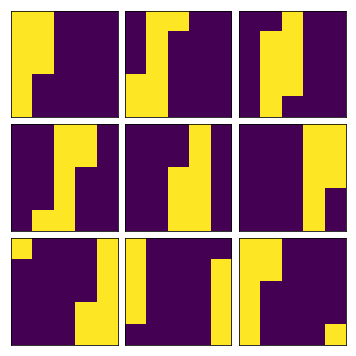

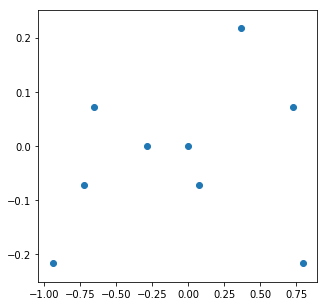

Average number of incoming EE connections: 8.840000
Average number of incoming EI connections: 12.600000
Average number of incoming IE connections: 11.720000
Average number of incoming PE connections: 14.600000
Average number of incoming PI connections: 7.960000


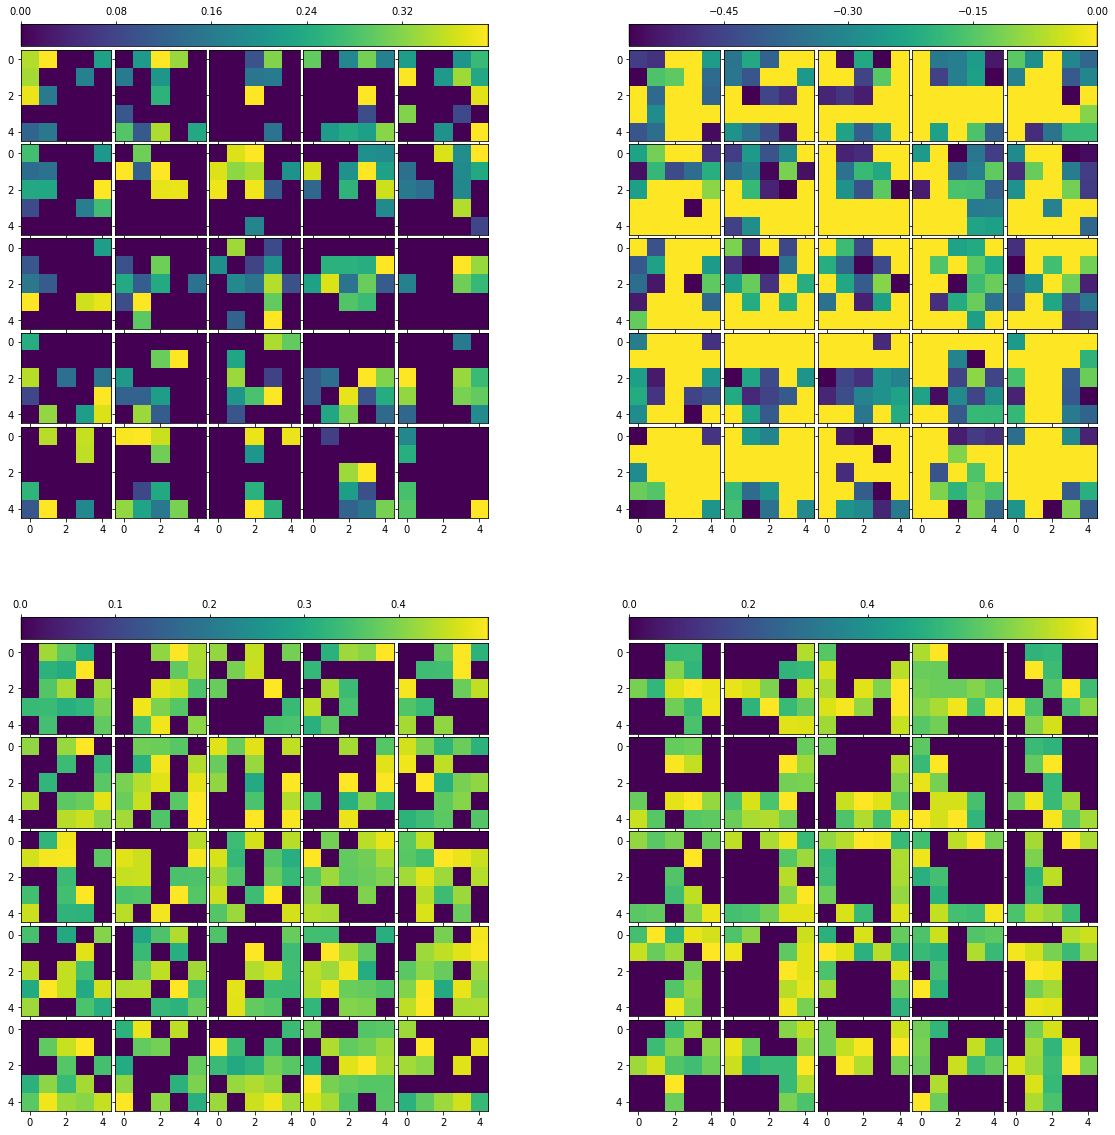

In [5]:
# visualize the patterns in a grid
inp_fig = plt.figure(figsize=(6,8))
cols = int(np.ceil(np.sqrt(n_pat)))
rows = int(round(np.sqrt(n_pat)))
inp_grid = ImageGrid(inp_fig, 111, nrows_ncols=(rows,cols), axes_pad=0.1, direction='row')

for idx,pat in enumerate(patterns):
    copy = pat.copy() # to avoid reshaping the input vectors
    copy.shape = N,N
    copy = np.transpose(copy)
    inp_grid[idx].set_xticks([])
    inp_grid[idx].set_yticks([])
    inp_grid[idx].imshow(copy)
    
plt.show()

# Find the centers of the patterns
centers = [np.zeros(2) for _ in range(len(patterns))]
for num, pat in enumerate(patterns):
    pat_coords = [ u.coordinates for u in [ net.units[i] for i in inp if pat[i - inp[0]] > 0 ] ]
    centers[num] = sum(pat_coords)/len(pat_coords)
    
cen_fig = plt.figure(figsize=(5,5))
plt.scatter([c[0] for c in centers], [c[1] for c in centers])
plt.show()

# print average number of connections of each type
sum_ee = 0 # number of e-e connections
sum_ei = 0
sum_ie = 0
sum_pe = 0 # number of input to exc connections
sum_pi = 0
for syn_list in net.syns:
    for syn in syn_list:
        if syn.postID in exc:
            if syn.preID in exc:
                sum_ee += 1
            elif syn.preID in inh:
                sum_ie += 1
            else:
                sum_pe += 1
        elif syn.postID in inh:
            if syn.preID in exc:
                sum_ei += 1
            else:
                sum_pi += 1
print("Average number of incoming EE connections: %f" % (sum_ee/(N*N)))
print("Average number of incoming EI connections: %f" % (sum_ei/(N*N)))
print("Average number of incoming IE connections: %f" % (sum_ie/(N*N)))
print("Average number of incoming PE connections: %f" % (sum_pe/(N*N)))
print("Average number of incoming PI connections: %f" % (sum_pi/(N*N)))

# Visualize the initial weights
exc_w = [np.zeros(N*N) for _ in range(N*N)]
inh_w = [np.zeros(N*N) for _ in range(N*N)]
inp_w = [np.zeros(N*N) for _ in range(N*N)]
e2i_w = [np.zeros(N*N) for _ in range(N*N)]
for u in exc: # for each excitatory unit, record its incoming weights
    for syn_list in [net.syns[u]]: # recording weights for excitatory units
        for syn in syn_list:
            if syn.preID in exc: # lateral excitatory connection
                exc_w[u-exc[0]][syn.preID-exc[0]] = syn.w
            elif syn.preID in inh: # lateral inhibitory connection
                inh_w[u-exc[0]][syn.preID-inh[0]] = syn.w
            elif syn.preID in inp: # descending connection
                inp_w[u-exc[0]][syn.preID-inp[0]] = syn.w
            else:
                print("What???")
                
for u in inh: # temporary code
    for syn_list in [net.syns[u]]:
        for syn in syn_list:
            if syn.preID in exc:
                e2i_w[u-inh[0]][syn.preID-exc[0]] = syn.w

w_fig = plt.figure(figsize=(20,20))

exw_grid = ImageGrid(w_fig, 221, nrows_ncols=(N,N), share_all=True, label_mode="L",
                     axes_pad=0.05, cbar_location="top", cbar_mode="single", )
for idx,exw in enumerate(exc_w):
    exw.shape = N,N
    exim = exw_grid[idx].imshow(exw)
exw_grid.cbar_axes[0].colorbar(exim)

inw_grid = ImageGrid(w_fig, 222, nrows_ncols=(N,N), share_all=True, label_mode="L",
                     axes_pad=0.05, cbar_location="top", cbar_mode="single", )
for idx,inw in enumerate(inh_w):
    inw.shape = N,N
    inim = inw_grid[idx].imshow(inw)
inw_grid.cbar_axes[0].colorbar(inim)
    
ipw_grid = ImageGrid(w_fig, 223, nrows_ncols=(N,N), share_all=True, label_mode="L",
                     axes_pad=0.05, cbar_location="top", cbar_mode="single", )
for idx,ipw in enumerate(inp_w):   
    ipw.shape = N,N
    ipim = ipw_grid[idx].imshow(ipw)
ipw_grid.cbar_axes[0].colorbar(ipim)

e2i_grid = ImageGrid(w_fig, 224, nrows_ncols=(N,N), share_all=True, label_mode="L",
                     axes_pad=0.05, cbar_location="top", cbar_mode="single", )
for idx,eiw in enumerate(e2i_w):   
    eiw.shape = N,N
    eiim = e2i_grid[idx].imshow(eiw)
e2i_grid.cbar_axes[0].colorbar(eiim)
    
plt.show()

Execution time: at iteration 0 is 8.432820320129395 seconds


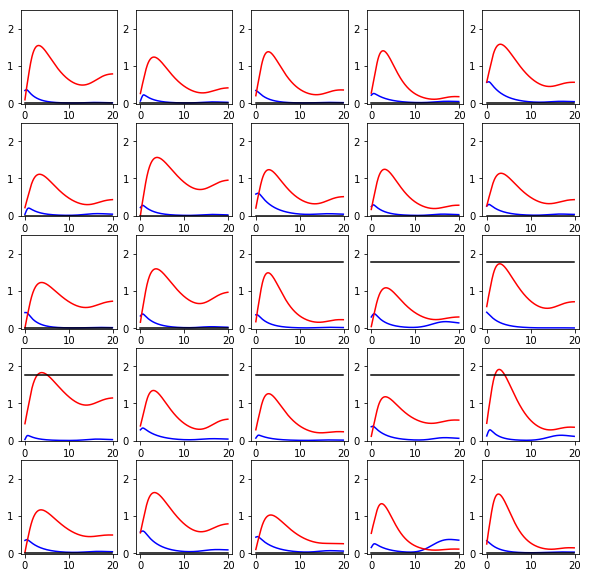

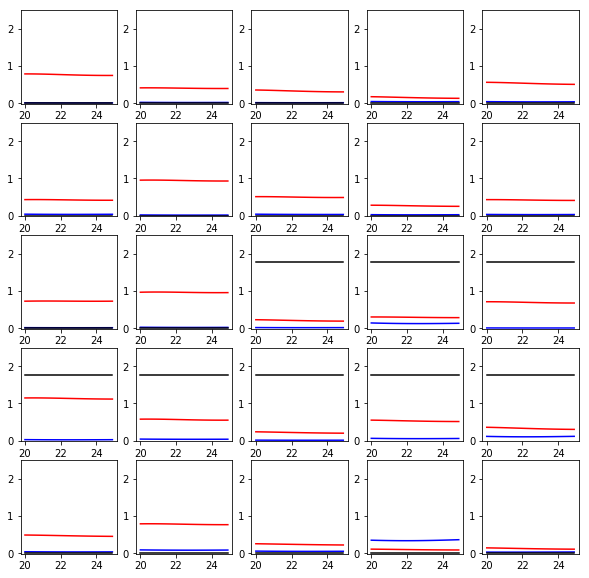

Presentation 1
Execution time: at iteration 1 is 8.034854888916016 seconds
Execution time: at iteration 2 is 8.209938049316406 seconds
Execution time: at iteration 3 is 8.819349765777588 seconds
Execution time: at iteration 4 is 8.956481695175171 seconds
Execution time: at iteration 5 is 8.857028007507324 seconds
Execution time: at iteration 6 is 8.735433101654053 seconds
Execution time: at iteration 7 is 8.410339593887329 seconds
Execution time: at iteration 8 is 8.47800350189209 seconds
Execution time: at iteration 9 is 8.2587890625 seconds
Execution time: at iteration 10 is 8.351307392120361 seconds
Execution time: at iteration 11 is 8.563384294509888 seconds
Execution time: at iteration 12 is 8.526615381240845 seconds
Execution time: at iteration 13 is 8.625340938568115 seconds
Execution time: at iteration 14 is 8.929133176803589 seconds
Execution time: at iteration 15 is 8.934447050094604 seconds
Execution time: at iteration 16 is 8.64995789527893 seconds
Execution time: at iterat

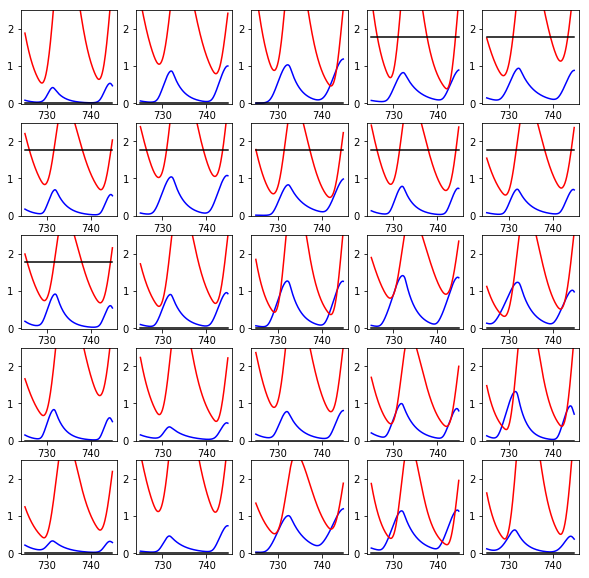

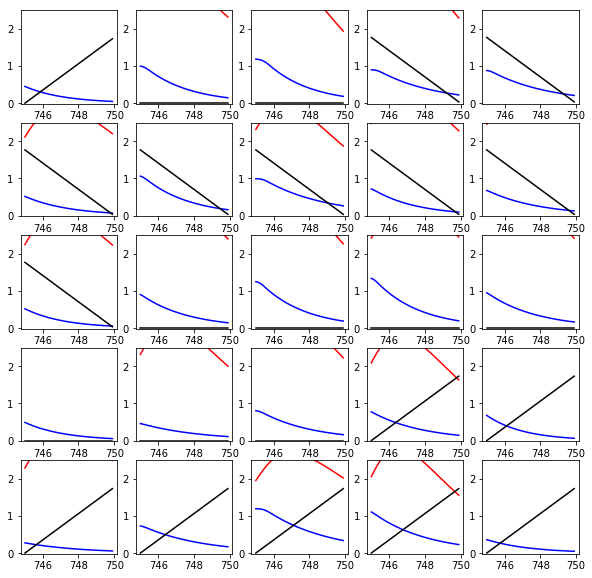

Presentation 30
Execution time: at iteration 30 is 8.998907804489136 seconds
Execution time: at iteration 31 is 9.117567539215088 seconds
Execution time: at iteration 32 is 9.443907976150513 seconds
Execution time: at iteration 33 is 9.623224020004272 seconds
Execution time: at iteration 34 is 10.45558214187622 seconds
Execution time: at iteration 35 is 9.130701541900635 seconds
Execution time: at iteration 36 is 9.324042081832886 seconds
Execution time: at iteration 37 is 9.181533575057983 seconds
Execution time: at iteration 38 is 9.333972454071045 seconds
Execution time: at iteration 39 is 9.313401222229004 seconds
Execution time: at iteration 40 is 9.280176639556885 seconds
Execution time: at iteration 41 is 8.9135422706604 seconds
Execution time: at iteration 42 is 9.245544672012329 seconds
Execution time: at iteration 43 is 9.268829107284546 seconds
Execution time: at iteration 44 is 9.58886456489563 seconds
Execution time: at iteration 45 is 9.21740436553955 seconds
Execution ti

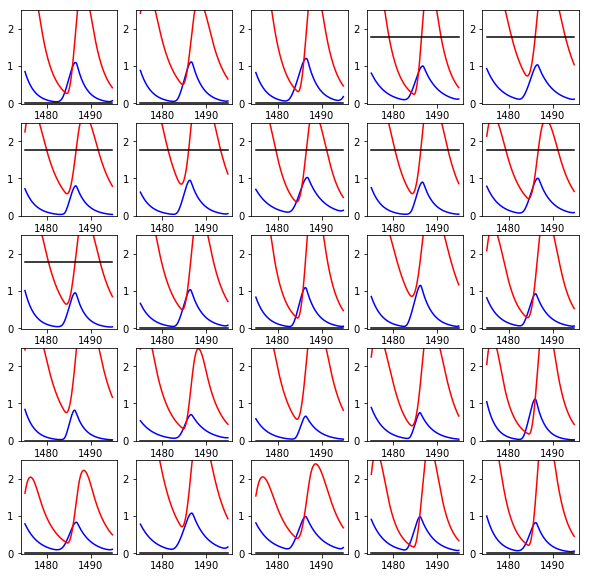

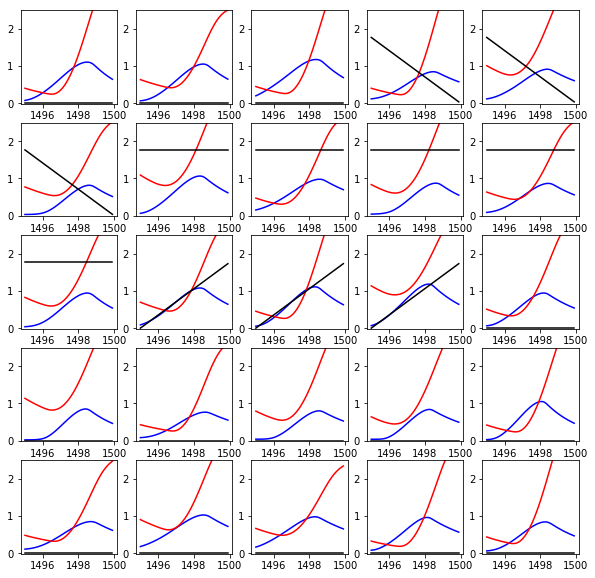

Presentation 60
Execution time: at iteration 60 is 9.302758693695068 seconds
Execution time: at iteration 61 is 9.30562686920166 seconds
Execution time: at iteration 62 is 9.109184265136719 seconds
Execution time: at iteration 63 is 9.532803297042847 seconds
Execution time: at iteration 64 is 8.9560866355896 seconds
Execution time: at iteration 65 is 9.033958435058594 seconds
Execution time: at iteration 66 is 8.64236044883728 seconds
Execution time: at iteration 67 is 8.710158824920654 seconds
Execution time: at iteration 68 is 8.819158792495728 seconds
Execution time: at iteration 69 is 9.024869441986084 seconds
Execution time: at iteration 70 is 8.36713457107544 seconds
Execution time: at iteration 71 is 8.28286361694336 seconds
Execution time: at iteration 72 is 8.434512376785278 seconds
Execution time: at iteration 73 is 8.488564491271973 seconds
Execution time: at iteration 74 is 9.262226343154907 seconds
Execution time: at iteration 75 is 9.460161209106445 seconds
Execution time

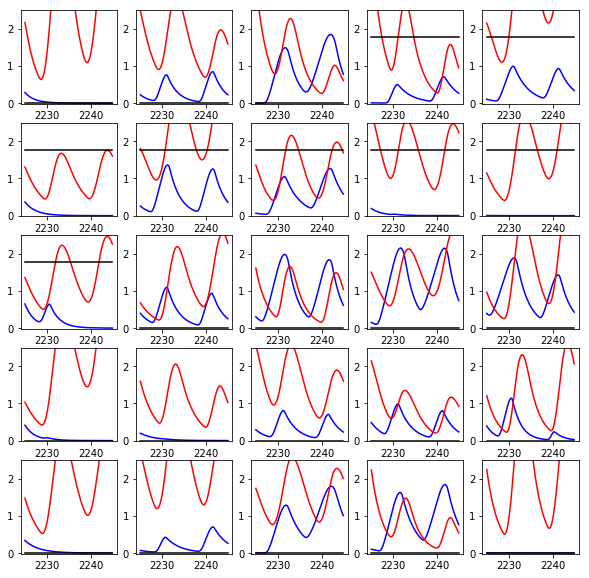

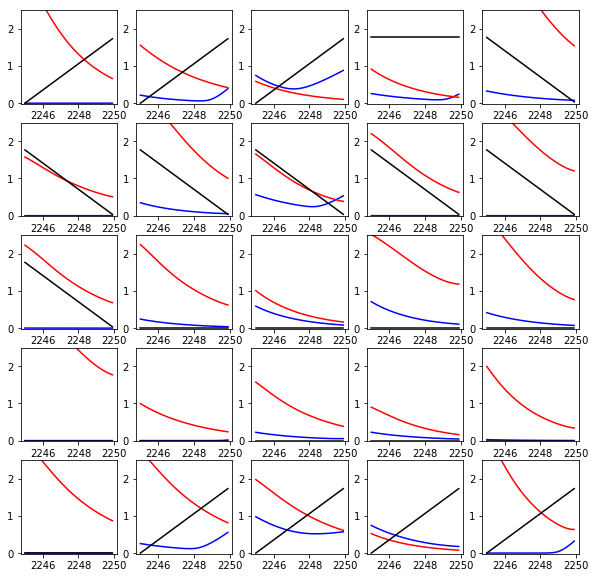

Presentation 90
Execution time: at iteration 90 is 9.73191237449646 seconds
Execution time: at iteration 91 is 9.57268214225769 seconds
Execution time: at iteration 92 is 9.397815704345703 seconds
Execution time: at iteration 93 is 9.437143325805664 seconds
Execution time: at iteration 94 is 9.443403005599976 seconds
Execution time: at iteration 95 is 9.970959663391113 seconds
Execution time: at iteration 96 is 10.440831661224365 seconds
Execution time: at iteration 97 is 9.221364259719849 seconds
Execution time: at iteration 98 is 8.679452180862427 seconds
Execution time: at iteration 99 is 8.87855863571167 seconds
Execution time: at iteration 100 is 8.84932541847229 seconds
Execution time: at iteration 101 is 9.15300178527832 seconds
Execution time: at iteration 102 is 8.746273756027222 seconds
Execution time: at iteration 103 is 9.0469651222229 seconds
Execution time: at iteration 104 is 9.028408765792847 seconds
Execution time: at iteration 105 is 9.094449758529663 seconds
Executio

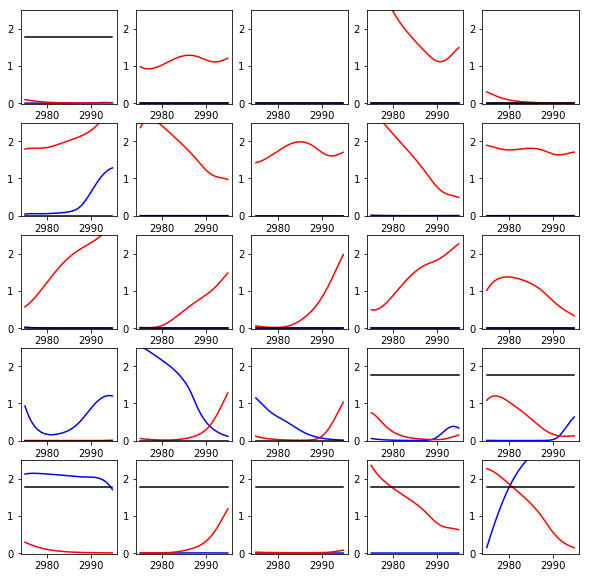

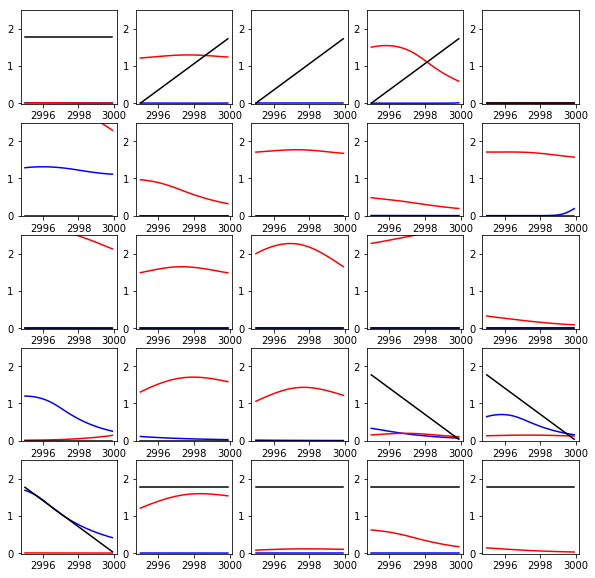

Presentation 120
Execution time: at iteration 120 is 9.110525846481323 seconds


In [6]:
'''Run the simulation. '''

### Pattern pat1 is presented alone for t_pat time units, and then there is a transition period
### during which pat1 becomes pat2 by presenting at time t an input 
### c*(t_pat+t_trans - t)*pat1 + c*(t - tpat)*pat2
### where c = 1/t_trans, and t_trans is the duration of the transition period. 
### At time t_pat+t_trans, pat2 is presented by itself for t_pat time units.
n_pres = 121   # number of times some pattern will be presented
n_disp = 4# How many times to store/display simulation data (besides the initial one)
t_pat = 20. # time each pattern will be presented
t_trans = 5. # length of transition period between patterns
interv = int(np.floor(n_pres/n_disp)) # number of iterations per data display
idx_d = 0 # index for display data
c = 1/t_trans # auxiliary variable for make_fun2
pats = range(n_pat) # auxiliary variable to choose a pattern
cur_pat = np.random.choice(pats)  # pattern currently presented
next_pat = np.random.choice(pats) # next pattern to be presented
last_t = 0. # simulation time after last pattern presentation, for make_fun2
exc_w = [[] for _ in range(n_disp+1)]  # to show the evolution of excitatory connections
inh_w = [[] for _ in range(n_disp+1)]  # to show the evolution of inhibitory connections
inp_w = [[] for _ in range(n_disp+1)]  # to show the evolution of input connections
#e2i_w = [[] for _ in range(n_disp+1)]  # temporarily used for testing
start_time = time.time()

def make_fun1(idx):  
    # This creates a constant function with value: patterns[cur_pat][idx]
    # thus avoiding a scoping problem that is sometimes hard to see:
    # https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/
    fun = lambda t : patterns[cur_pat][idx]
    return fun

def make_fun2(idx, last_t):
    # Creates a function for the pattern transition
    fun = lambda t : c * ( (t_trans - (t-last_t))*patterns[cur_pat][idx] +
                           (t-last_t)*patterns[next_pat][idx] )
    return fun

for pres in range(n_pres):
# For each cycle you'll set the input functions and simulate, once with a single pattern,
# once with a mix of patterns, as described above
    
    # first, we present a single pattern
    for u in range(N*N):
        net.units[inp[u]].set_function( make_fun1(u) )
    
    start_time = time.time()
    sim_dat = net.run(t_pat)  # simulating
    last_t = net.sim_time # simulation time after last pattern presentation
    
    #plot_stuff(sim_dat, exc, inh, inp)
    #input('Fixed pattern presented: ' + str(cur_pat))
    
    # now one pattern turns into the next
    for u in range(N*N):
        net.units[inp[u]].set_function(make_fun2(u, last_t))
    
    sim_dat2 = net.run(t_trans) # simulating
    
    print('Execution time: at iteration %d is %s seconds' % (pres, (time.time() - start_time)) )
    #plot_stuff(sim_dat, exc, inh, inp)
    #input('Transitioned to pattern: ' + str(next_pat))

    # choose the pattern you'll present next
    cur_pat = next_pat
    next_pat = np.random.choice(pats)
    
    if pres == 0 or (pres+1)%interv == 0:
        plot_stuff(sim_dat, exc, inh, inp)
        plot_stuff(sim_dat2, exc, inh, inp)
        # store the synaptic weights
        exc_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        inh_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        inp_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        #e2i_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        for u in exc: # for each excitatory unit, record its incoming weights
            for syn_list in [net.syns[u]]: # recording weights for excitatory units
                for syn in syn_list:
                    if syn.preID in exc: # lateral excitatory connection
                        exc_w[idx_d][u][syn.preID-exc[0]] = syn.w
                    elif syn.preID in inh: # lateral inhibitory connection
                        inh_w[idx_d][u][syn.preID-inh[0]] = syn.w
                    elif syn.preID in inp: # descending connection
                        inp_w[idx_d][u][syn.preID-inp[0]] = syn.w
                    else:
                        print("What???")
                        
        print('Presentation ' + str(pres+1))
        idx_d += 1

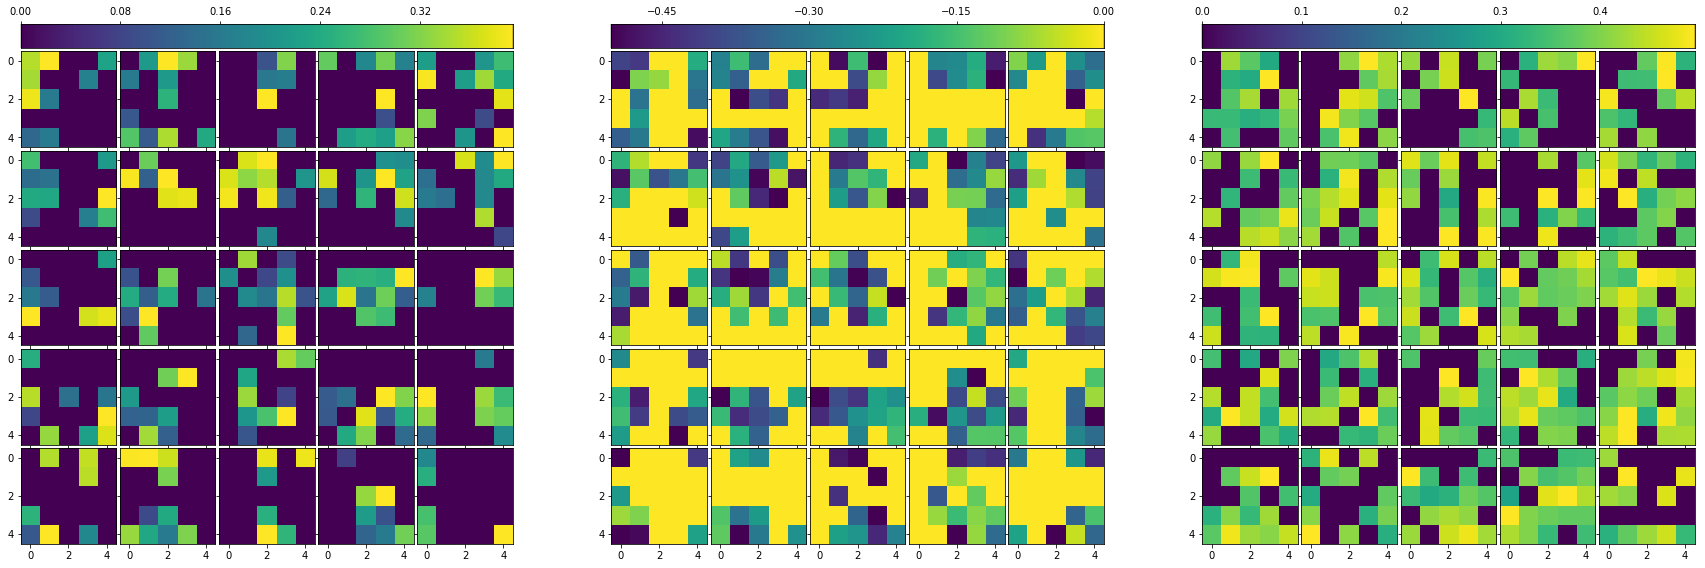

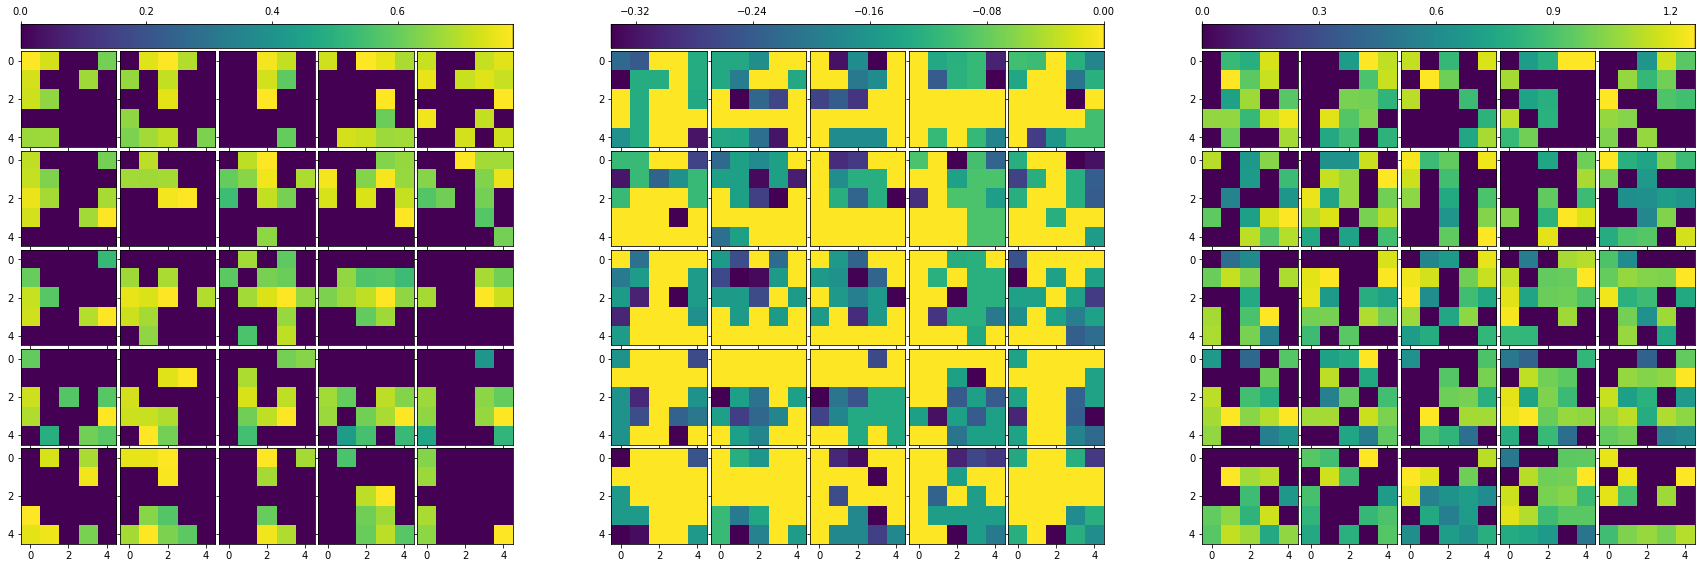

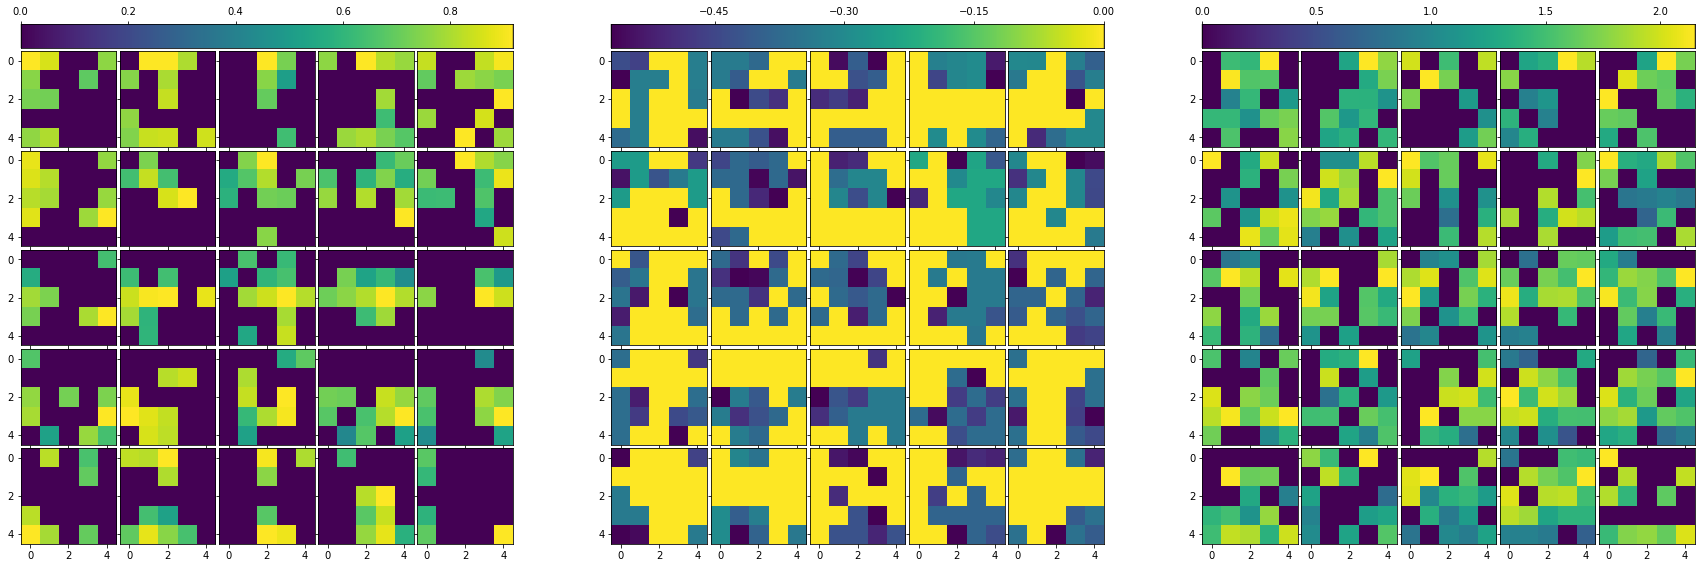

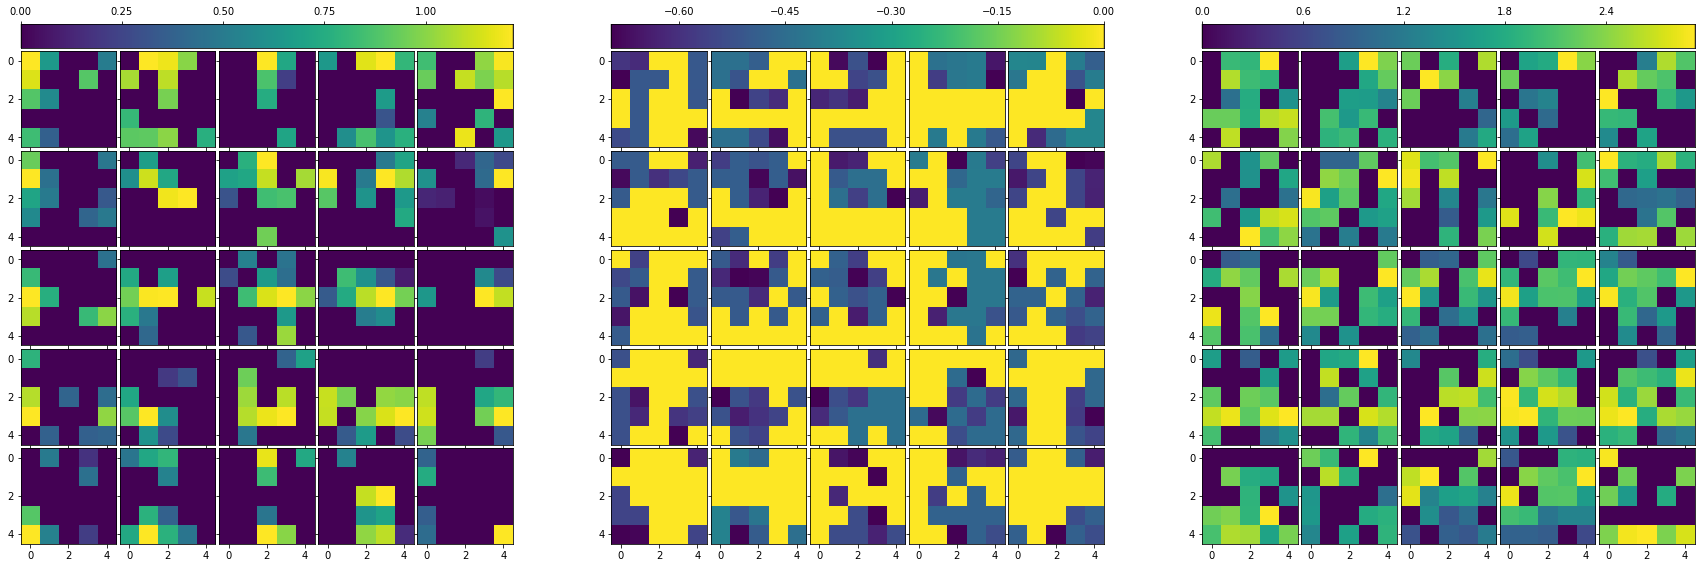

Excitatory sums:	[1.3966519793641898, 2.4856094322535474, 2.5000888017370695, 2.5005971975690517]
Inhibitory sums:	[-4.2655570247151786, -2.1923885123878888, -4.0532404808484763, -7.2965515083281822]
External input sums: 	[5.8668339015768511, 14.954231910365522, 23.712179690547067, 32.34945813785307]


In [7]:
# visualize the weights in a grid

for vis in range(n_disp):
    w_fig = plt.figure(figsize=(30,10))

    exw_grid = ImageGrid(w_fig, 131, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", )
    for idx,exw in enumerate(exc_w[vis]):
        exw.shape = N,N
        exim = exw_grid[idx].imshow(exw)
    exw_grid.cbar_axes[0].colorbar(exim)
    
    inw_grid = ImageGrid(w_fig, 132, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", )
    for idx,inw in enumerate(inh_w[vis]):
        inw.shape = N,N
        inim = inw_grid[idx].imshow(inw)
    inw_grid.cbar_axes[0].colorbar(inim)
    
    ipw_grid = ImageGrid(w_fig, 133, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", )
    for idx,ipw in enumerate(inp_w[vis]):
        ipw.shape = N,N
        ipim = ipw_grid[idx].imshow(ipw)
    ipw_grid.cbar_axes[0].colorbar(ipim)
    
    plt.show()
    
# see how the sum of each type of input evolves for unit 0
exc_sums = [sum(sum(exc_w[ii][0]*exc_w[ii][0])) for ii in range(n_disp)]
inh_sums = [sum(sum(inh_w[ii][0])) for ii in range(n_disp)]
inp_sums = [sum(sum(inp_w[ii][0])) for ii in range(n_disp)]
print("Excitatory sums:", end='\t')
print(exc_sums)
print("Inhibitory sums:", end='\t')
print(inh_sums)
print("External input sums:", end=' \t')
print(inp_sums)


The point of these simulations is to find whether the E-I network with the type of plasticity from Moldakarinov06 is suited for becoming a network where each unit selects a particular subset of the descending inputs.

Due to the topological arrangement of the connections, it is reasonable to assume that spatially structured inputs, such as the "progressive lines" will have patterns that target some units slightly more than others. The point is for the network to pick on those slight preferences and to enhance them using the lateral connections as exta constraints.

In the case of the progressive lines we can: 
* find a 'center' for each pattern, as the average of the coordinates for each unit that is on when the pattern is present. That's the 'centers' vector obtained above.
* for each excitatory unit, measure its average activity level for each pattern. 
* plot what is the correlation between the distance to a pattern VS the activity level when the pattern is presented.
  This can be done in first vs last iterations.

Execution time: at iteration 120 is 8.70552682876587 seconds


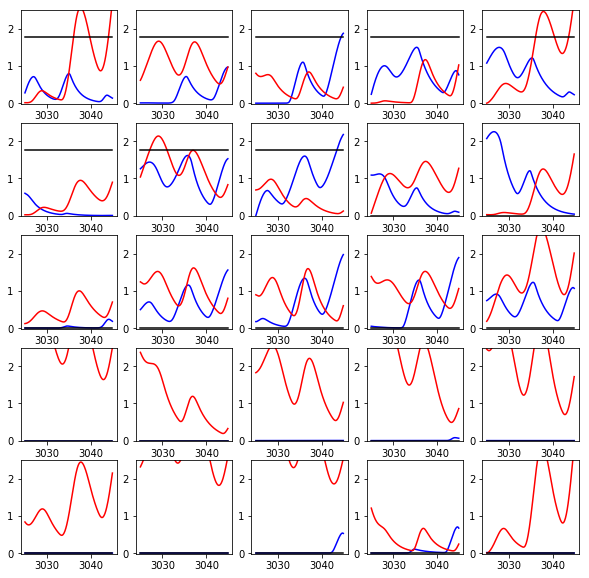

Presented pattern: 0


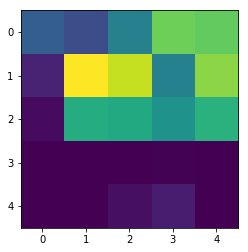

Execution time: at iteration 120 is 9.24728512763977 seconds


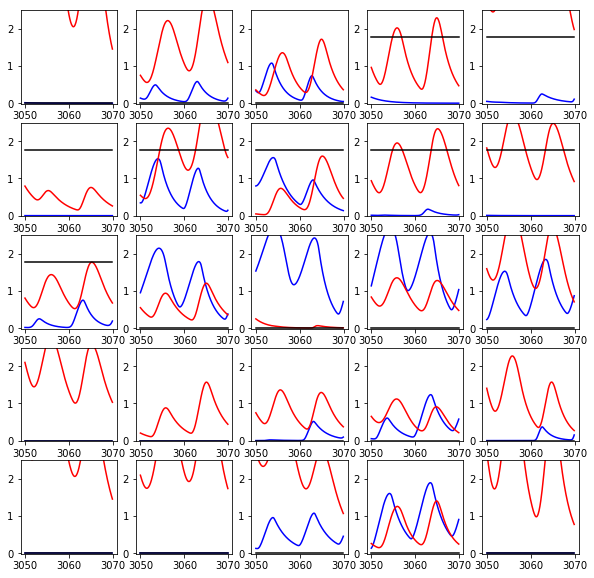

Presented pattern: 1


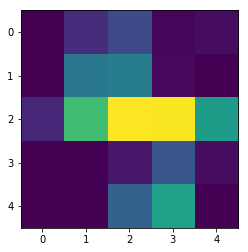

Execution time: at iteration 120 is 9.537551164627075 seconds


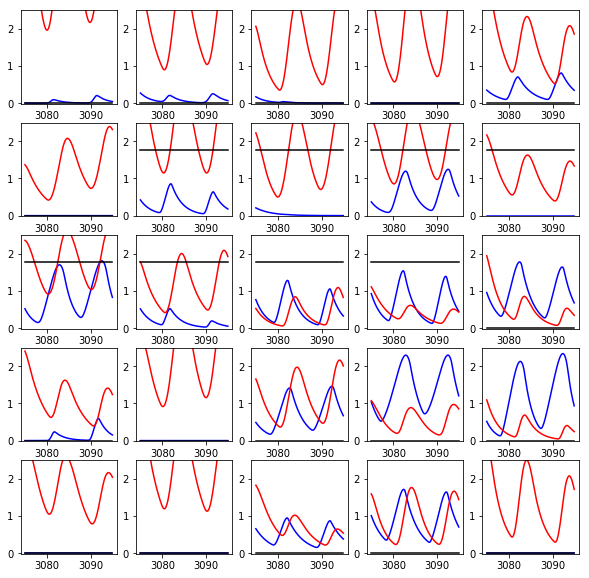

Presented pattern: 2


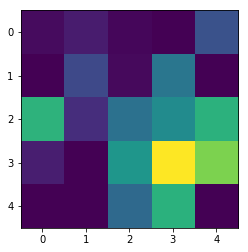

Execution time: at iteration 120 is 10.599009037017822 seconds


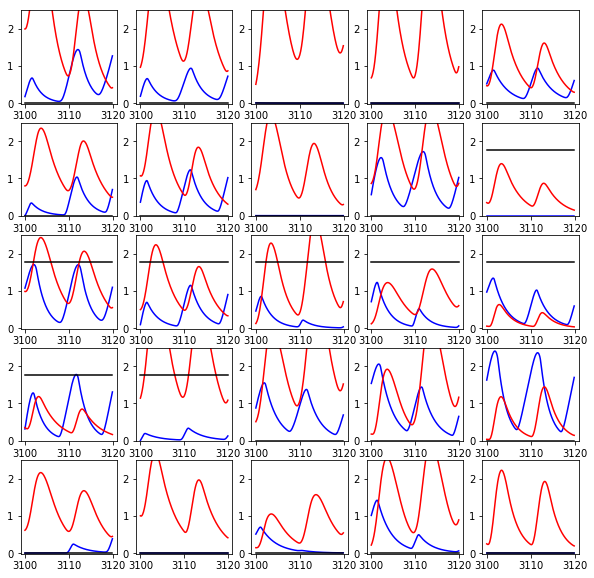

Presented pattern: 3


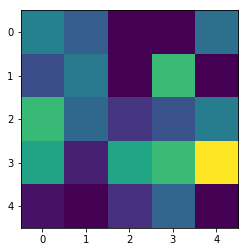

Execution time: at iteration 120 is 9.048420906066895 seconds


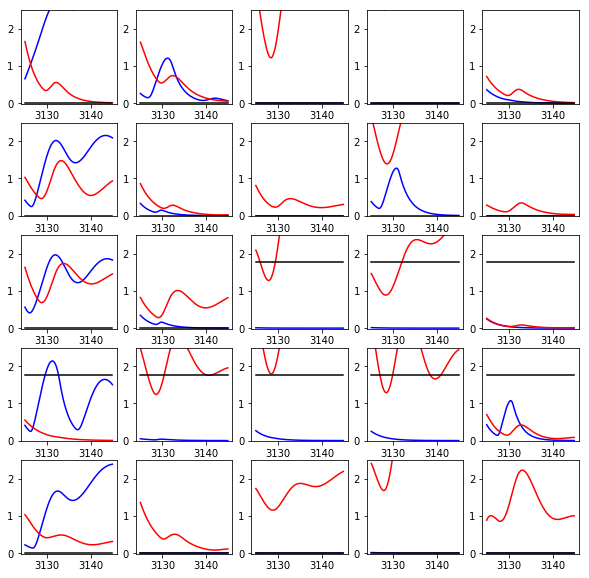

Presented pattern: 4


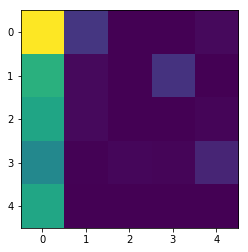

Execution time: at iteration 120 is 8.975246667861938 seconds


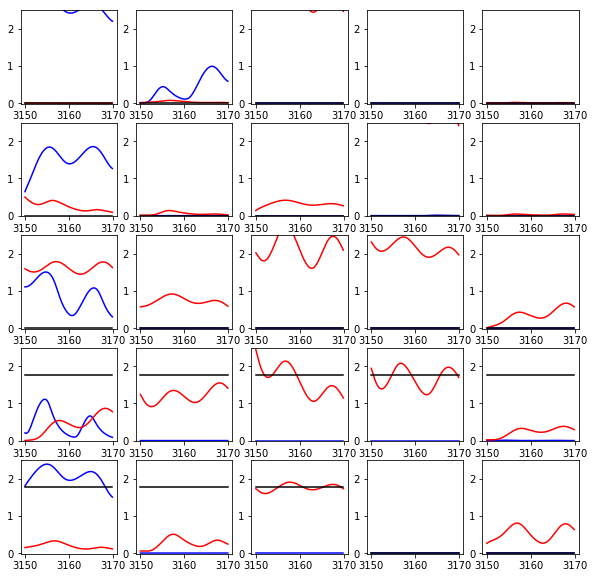

Presented pattern: 5


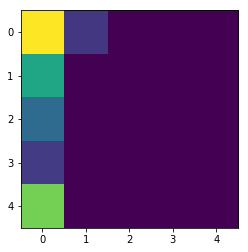

Execution time: at iteration 120 is 8.91975212097168 seconds


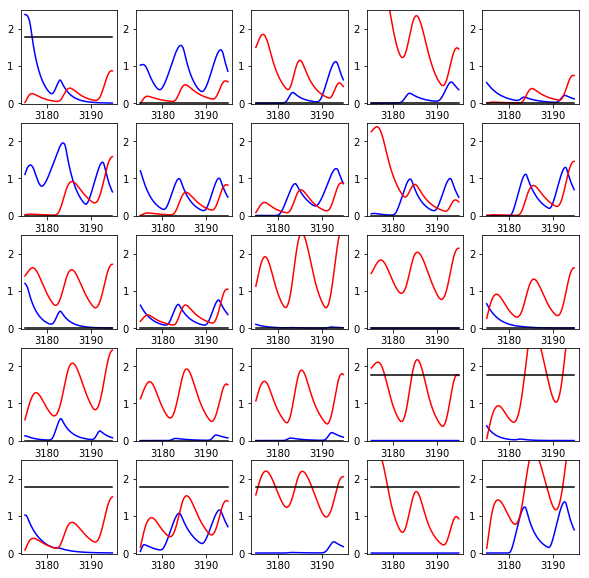

Presented pattern: 6


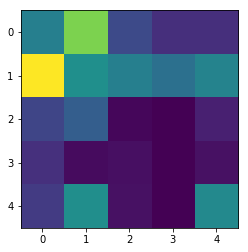

Execution time: at iteration 120 is 9.620529651641846 seconds


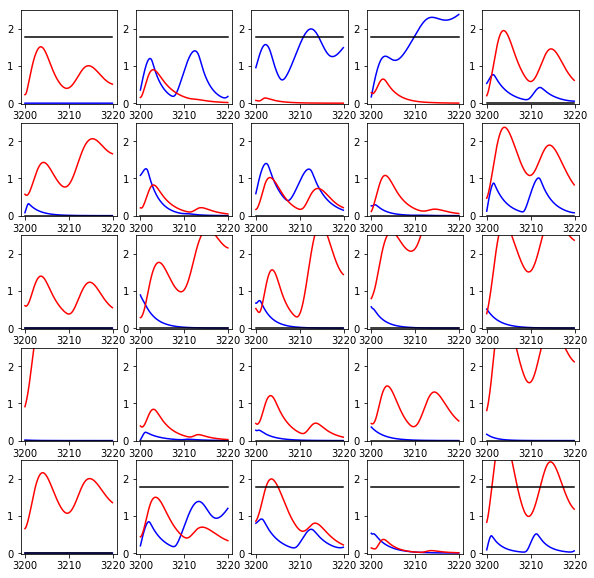

Presented pattern: 7


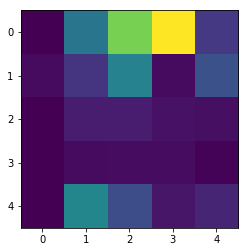

Execution time: at iteration 120 is 9.789522886276245 seconds


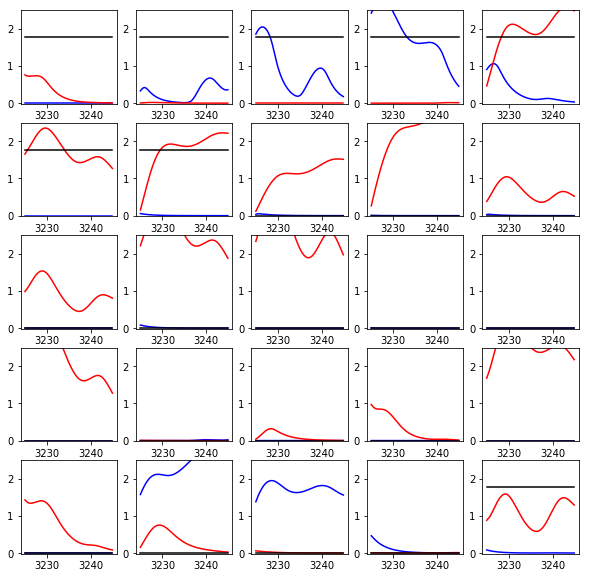

Presented pattern: 8


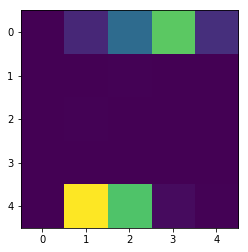

In [8]:
""" Next, test if the cells are selective to some of the patterns. Present the five patterns,
and see the average response value. """
avg_res = [np.zeros(N*N) for _ in range(n_pat)] # for each pattern, average activity of each unit

# presenting all paterns
for num, pat in enumerate(patterns):
    # first, we present a single pattern
    cur_pat = num
    for u in range(N*N):
        net.units[inp[u]].set_function( make_fun1(u) )
    
    start_time = time.time()
    times, units, plants = net.run(t_pat)  # simulating
    last_t = net.sim_time # simulation time after last pattern presentation
    
    for u in range(N*N):
        avg_res[num][u] = sum(units[exc[u]]) / len(units[exc[u]])
    
    # now one pattern turns into the next
    for u in range(N*N):
        net.units[inp[u]].set_function(make_fun2(u, last_t))
    
    sim_dat2 = net.run(t_trans) # simulating
    
    print('Execution time: at iteration %d is %s seconds' % (pres, (time.time() - start_time)) )
    plot_stuff((times, units, plants), exc, inh, inp)
    print('Presented pattern: ' + str(num))
    
    # plot a grid with the average responses
    avg_fig, avg_ax = plt.subplots()
    avg_res[num].shape = N,N 
    avg_ax.imshow(avg_res[num])
    plt.show()
    

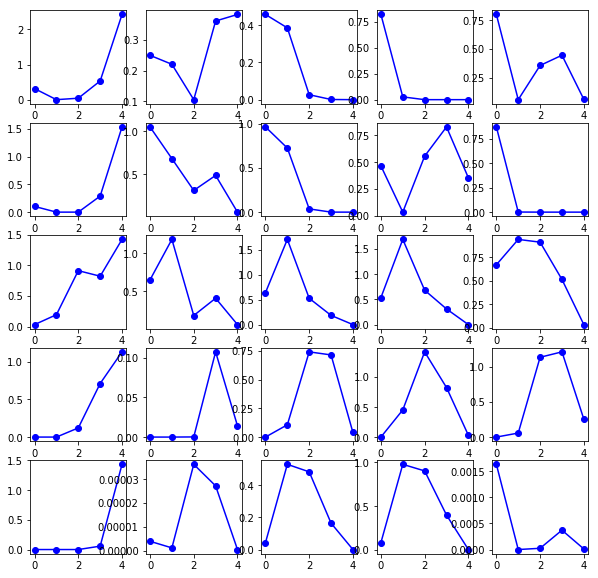

In [9]:
# For each unit, plot its avg. response for each pattern
all_avg_fig = plt.figure(figsize=(10,10))
for res in avg_res:
    res.shape = N*N
for u in range(N*N):
    ax = all_avg_fig.add_subplot(N,N,u+1)
    ax.plot(range(N), [avg_res[i][u] for i in range(N)], 'bo-')
    
plt.show()

This figure shows that units become very selective to particular patterns, and the number of units devoted to each pattern is evenly distributed. It is not quite how I imagined it, but it couldn't be better.

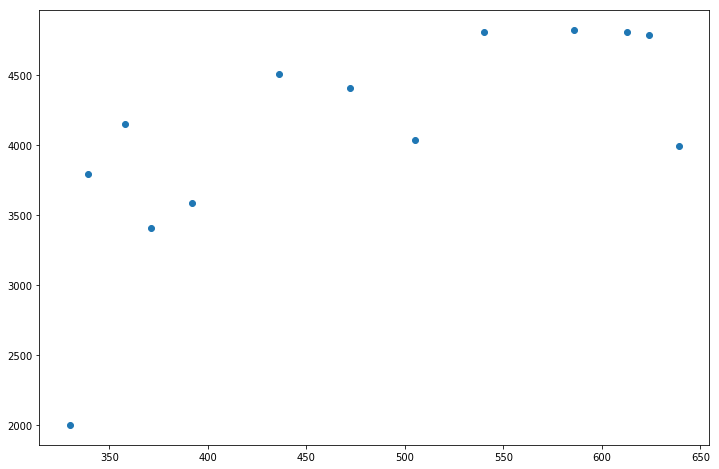

In [10]:
gas = [[(20,3,17),4033], [(17,2,17), 4410], [(12,1,17),4511], [(27,11,16),3586], [(24,10,16),4153], [(5,10,16),3796],
 [(26,9,16),2000], [(31,7,17), 3992], [(9,6,17), 4824], [(24,4,17), 4811], [(5,7,17), 4810], [(6,11,16),3410],
 [(16,7,17), 4783]]
days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
cumdays = [days[0]] + [0] * 11
for i in range(1,12):
    cumdays[i] = days[i] + cumdays[i-1]
dates = [ e[0][0] + cumdays[e[0][1]] + sum(days)*(e[0][2] - 16) for e in gas]
prices = [e[1] for e in gas]
fig = plt.figure(figsize=(12,8))
plt.plot(dates, prices, 'o')
plt.show()

In [11]:
even = list(range(0, N*N, 2))
odd = list(range(1, N*N, 2))
advance = int(round(N*N/n_pat))
base = np.zeros(N*N)
base[even] = np.ones(len(even))
print(base)
base = np.roll(base,1)
print(base)

[ 1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  0.  1.  0.  1.]
[ 1.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.
  0.  1.  0.  1.  0.  1.  0.]
